UCEC Reccurance Notebook

Importing data from ucec_tcga_pan_can_atlas_2018

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline

from collections import Counter
import matplotlib.pyplot as plt


In [2]:
mrna_df = pd.read_csv("ucec_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt", sep="\t", comment="#")
# I appear to have 527 patients in the mRNA and 529 patients in the clinical data

clinical_df = pd.read_csv("ucec_tcga_pan_can_atlas_2018\data_clinical_patient.txt", sep="\t", comment="#", low_memory=False)
clinical_df = clinical_df.set_index('PATIENT_ID')

# The first 2 columns of the mRNA data are labels. 13 of the genes do not have Hugo_symbols, so I am putting placeholder stings as labels for these genes
missing_symbols = mrna_df['Hugo_Symbol'].isnull()
mrna_df.loc[missing_symbols, 'Hugo_Symbol'] = [
    f'no_symbol_{i+1}' for i in range(missing_symbols.sum())
]

# Get value counts
counts = mrna_df['Hugo_Symbol'].value_counts()

# Generate unique labels for duplicates
def label_duplicates(value, index):
    if counts[value] == 1:
        return value  # Keep unique values unchanged
    occurrence = mrna_df.groupby('Hugo_Symbol').cumcount() + 1  # Count occurrences per group
    return f"{value}-{occurrence[index]}-of-{counts[value]}"

# Apply the labeling function
mrna_df['Hugo_Symbol'] = [label_duplicates(value, idx) for idx, value in mrna_df['Hugo_Symbol'].items()]

mrna_df = mrna_df.set_index('Hugo_Symbol')
mrna_df = mrna_df.drop(columns="Entrez_Gene_Id") # removing the label column before I transpose the df
mrna_df_transposed= mrna_df.transpose()
mrna_df_transposed.index = [id[:-3] for id in mrna_df_transposed.index] # removes extranious -01 so that the patient ids match the clinical data

df = clinical_df.join(mrna_df_transposed, how='inner') # this is the data frame for clinical and genetic data. It has 527 patients (rows) and 20568 features (columns).

In [3]:
#testing around
df["FKSG73"]
unique_values = df["FKSG73"].nunique(dropna=True)
print(unique_values)

counts = Counter(df["FKSG73"].dropna())

# Print unique values and their counts
for item, count in counts.items():
    print(f"{item}: {count}")


3
-3.7272: 171
-1.0: 1
1.0: 1


The following genes appear in the data more than once but have different data: 
['PALM2AKAP2', 'ELMOD1', 'FGF13', 'QSOX1', 'SNAP47', 'NKAIN3', 'TMEM8B']
Right now, I'm leaving every version of the gene in, but giving placeholder unique names like: PALM2AKAP2-1-of-2 and PALM2AKAP2-2-of-2

Removing unecessary columns from clinical data.

In [4]:
MAX_NULL_VALS = 0.3

def assign_label(row):
    '''given a row assigns 1 for recurrance and 0 for no recurrance. 
    Currently uses NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT to identify recurrance.
    If NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT is NaN, uses DSF_STATUS'''
    if row['NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT'] == 'Yes':
        return 1
    elif row['NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT'] == 'No':
        return 0
    elif pd.isna(row['NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT']):
        if row['DFS_STATUS'] == '1:Recurred/Progressed':
            return 1
        elif row['DFS_STATUS'] == '0:DiseaseFree':
            return 0
        else:
            raise ValueError(f"Error: Both columns are NaN at index {row.name}")

def drop_highly_uniform_columns(df, threshold=0.99):
    """
    Drops columns where more than 'threshold' proportion of non-NaN values are the same.

    Parameters:
    - df: pandas DataFrame
    - threshold: float (default 0.95), proportion threshold to drop columns

    Returns:
    - pandas DataFrame with specified columns dropped
    """
    cols_to_drop = []
    for col in df.columns:
        non_na_values = df[col].dropna()
        if not non_na_values.empty:
            top_freq = non_na_values.value_counts(normalize=True).iloc[0]
            if top_freq > threshold:
                cols_to_drop.append(col)
    return df.drop(columns=cols_to_drop)

drop_highly_uniform_columns(df)

# remove the column if over MAX_NULL_VALS percent null values
df = df.dropna(axis=1, thresh=len(df) * (1 - MAX_NULL_VALS))

# remove non-informational columns
df = df.drop(columns=['OTHER_PATIENT_ID'])

pair_counts = df.groupby(["NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT", 'DFS_STATUS'], dropna=False).size().reset_index(name='Count')

# Print the pairings and the count
print(pair_counts)

# I am going to remove the 32 rows where we have no recurrance label (neither NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT nor DFS_STATUS are known)
# PFS_STATUS
df = df.dropna(subset=['DFS_STATUS', 'NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT'], how='all')

# # numpy array for the Labels for recurrance
labels = np.array(df.apply(assign_label, axis=1)) 
#DIF DFI.time 

  NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT             DFS_STATUS  Count
0                                      No          0:DiseaseFree    326
1                                      No  1:Recurred/Progressed     12
2                                      No                    NaN     49
3                                     Yes          0:DiseaseFree      7
4                                     Yes  1:Recurred/Progressed     38
5                                     Yes                    NaN     34
6                                     NaN          0:DiseaseFree     24
7                                     NaN  1:Recurred/Progressed      5
8                                     NaN                    NaN     32


Transforms data by changing catagorical data into numerical data and filling in missing data points with medians or modes.

In [5]:
nan_counts = df.isnull().sum()
nonzero_nans = nan_counts[nan_counts > 0]
print("Columns with NaN values:")
print(nonzero_nans)


Columns with NaN values:
SUBTYPE                                     19
AGE                                          2
AJCC_STAGING_EDITION                        69
DAYS_LAST_FOLLOWUP                          33
DAYS_TO_BIRTH                                3
DAYS_TO_INITIAL_PATHOLOGIC_DIAGNOSIS         5
ETHNICITY                                  146
NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT     29
PERSON_NEOPLASM_CANCER_STATUS               24
RACE                                        30
RADIATION_THERAPY                            6
WEIGHT                                      20
DSS_STATUS                                   2
DFS_STATUS                                  83
DFS_MONTHS                                  83
dtype: int64


In [ ]:
categorical_columns = ["ETHNICITY",
                        "ICD_10", 
                        "PRIOR_DX", 
                        "RACE",
                        "RADIATION_THERAPY", 
                        "IN_PANCANPATHWAYS_FREEZE", 
                        "GENETIC_ANCESTRY_LABEL"] #FIXME: do further research on what ICD_10 and ICD_O_3_SITE are

# Fill numerical NaNs with median
numerical_df = df.select_dtypes(include=['number'])
numerical_df = numerical_df.drop(columns=['OS_MONTHS', 'DSS_MONTHS', 'DFS_MONTHS', 'PFS_MONTHS'])
numerical_df = numerical_df.fillna(numerical_df.median())

# fill catagorical columns with mode
categorical_df = df[categorical_columns]
categorical_df = categorical_df.fillna(categorical_df.mode())


# One-Hot Encode categorical columns (drop first to avoid redundancy)
categorical_df = pd.get_dummies(categorical_df, drop_first=True, dtype=float)

X = pd.concat([numerical_df, categorical_df], axis=1)

# feature_names = {i: col for i, col in enumerate(X.columns)}
feature_names = X.columns
X = X.to_numpy()


Index(['AGE', 'AJCC_STAGING_EDITION', 'DAYS_TO_BIRTH',
       'DAYS_TO_INITIAL_PATHOLOGIC_DIAGNOSIS', 'WEIGHT', 'no_symbol_2',
       'UBE2Q2P2', 'HMGB1P1', 'no_symbol_3', 'no_symbol_5',
       ...
       'RADIATION_THERAPY_Yes', 'IN_PANCANPATHWAYS_FREEZE_Yes',
       'GENETIC_ANCESTRY_LABEL_ADMIX', 'GENETIC_ANCESTRY_LABEL_AFR',
       'GENETIC_ANCESTRY_LABEL_AFR_ADMIX', 'GENETIC_ANCESTRY_LABEL_AMR',
       'GENETIC_ANCESTRY_LABEL_EAS', 'GENETIC_ANCESTRY_LABEL_EUR',
       'GENETIC_ANCESTRY_LABEL_EUR_ADMIX', 'GENETIC_ANCESTRY_LABEL_SAS'],
      dtype='object', length=17531)


# Part 2: Training My Model

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=1, stratify=labels)

def run_random_forest_classifer():
    # Code for training Random Forest
    print("Running random forest classifier")
    pipeline = Pipeline([
        ('variance_threshold', VarianceThreshold(threshold=1e-5)), 
        ('scaler', StandardScaler()),
        ('select', SelectKBest(score_func=f_classif)),
        ('clf', RandomForestClassifier(random_state=100, class_weight='balanced'))
    ])

    # Define hyperparameter grid
    param_grid = {
        'clf__n_estimators': [50, 100],
        'clf__max_depth': [5, 10, 15],
        'clf__min_samples_split': [2, 4],
        'clf__min_samples_leaf': [1, 2, 4],
        'select__k': [20, 50, 100, 500],
        'clf__max_features': ['sqrt', 'log2', 0.1]  # Reduce feature space per tree
    }
    return pipeline, param_grid

def run_logistic_regression():
    # Define the pipeline with Logistic Regression
    print("Running Logistic Regression")
    pipeline = Pipeline([
        ('variance_threshold', VarianceThreshold(threshold=0.001)), 
        ('scaler', StandardScaler()),
        ('select', SelectKBest(score_func=f_classif, k=1000)),
        ('clf', LogisticRegression(class_weight='balanced', random_state=100))
    ])

    # define hyperparameter grid for logistic regression
    param_grid = {
        'clf__C': [0.01, 0.1, 1, 10, 100],
        'select__k': [50, 100, 500, 1000]
    }
    return pipeline, param_grid

def run_logistic_regression_with_LASSO():
    print("Running Logistic Regression with LASSO")

    pipeline = Pipeline([
        ('variance_threshold', VarianceThreshold(threshold=0.001)),
        ('scaler', StandardScaler()),
        ('select', SelectKBest(score_func=f_classif, k=1000)),
        ('clf', LogisticRegression(
            penalty='l1',
            solver='saga',
            class_weight='balanced',
            random_state=100,
            max_iter=10000,
            verbose=1
        ))
    ])

    param_grid = {
        'clf__C': [0.01, 0.1, 1, 10]  # Smaller C = more sparsity
    }

    return pipeline, param_grid

# Change which model you are using here
# pipeline, param_grid = run_random_forest_classifer()
# pipeline, param_grid = run_logistic_regression()
pipeline, param_grid = run_logistic_regression_with_LASSO()

# Set up cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=100)

# Grid search over pipeline
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',  # Or 'f1' if recurrence class is more important
    n_jobs=-1,
    verbose=3
)

# Fit pipeline on training data
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# [ 6416 12260 12263 12264 12392 12400 12416 12426 12431 12526 12527 12892 13602 14340 16428 18227 20043] are constant.

Running Logistic Regression with LASSO
Fitting 3 folds for each of 4 candidates, totalling 12 fits
convergence after 5766 epochs took 1143 seconds


Looking at the hyperparameter tuning

In [72]:
print("Overall best params:", grid_search.best_params_, "\n")

# Retrieve the results from grid search
cv_results = grid_search.cv_results_

# Extract the mean test scores for each parameter combination
mean_test_scores = cv_results['mean_test_score']

# Extract the standard deviation of test scores for each parameter combination
std_test_scores = cv_results['std_test_score']

# Extract the parameter settings for each run
params = cv_results['params']

# Print the AUC-ROC scores for each parameter combination
for mean, std, param in zip(mean_test_scores, std_test_scores, params):
    print(f"Parameters: {param}")
    print(f"Mean AUC-ROC: {mean:.4f}")
    print(f"Standard Deviation: {std:.4f}")
    print("-" * 30)


Overall best params: {'clf__C': 1} 

Parameters: {'clf__C': 0.001}
Mean AUC-ROC: 0.5000
Standard Deviation: 0.0000
------------------------------
Parameters: {'clf__C': 0.01}
Mean AUC-ROC: 0.5000
Standard Deviation: 0.0000
------------------------------
Parameters: {'clf__C': 0.1}
Mean AUC-ROC: 0.6235
Standard Deviation: 0.0225
------------------------------
Parameters: {'clf__C': 1}
Mean AUC-ROC: 0.6469
Standard Deviation: 0.0140
------------------------------


# this got overfitting but not 100% negative prediction (used k = 3)
Overall best params: {'clf__max_depth': 5, 'clf__min_samples_split': 4, 'clf__n_estimators': 50, 'select__k': 100} 

# this got 100% Negative prediction (used k = 7)
Overall best params: {'clf__max_depth': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 50, 'select__k': 1000} 

# this got AUC-ROC of 0.575 (using k = 3)
Overall best params: {'clf__max_depth': 5, 'clf__max_features': 'log2', 'clf__min_samples_split': 2, 'clf__n_estimators': 100, 'select__k': 100} 


Overall best params: {'clf__max_depth': 5, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 100, 'select__k': 100} 

# this what I got when I split 40% of data into the test, this one did really poorly (AUC-ROC = 0.49)
Overall best params: {'clf__max_depth': 10, 'clf__max_features': 0.1, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2, 'clf__n_estimators': 50, 'select__k': 500} 

FOR LOGISTIC REGRESSION:
# AUC-ROC of 0.69
Overall best params: {'clf__C': 0.01, 'select__k': 50} 

Analyzing the prediction of the training data

True Positives (TP): 67
False Positives (FP): 0
True Negatives (TN): 329
False Negatives (FN): 0
AUC-ROC Score: 1.0000


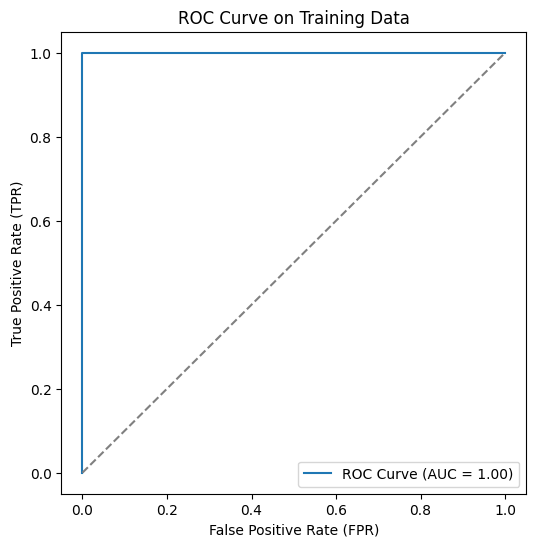

In [73]:
y_train_pred = best_model.predict(X_train)

cm_test = confusion_matrix(y_train, y_train_pred)
tn, fp, fn, tp = cm_test.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Compute the AUC-ROC score
roc_auc = roc_auc_score(y_train, y_train_pred)

# Print the AUC-ROC score
print(f"AUC-ROC Score: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_train, y_train_pred)

# Plot the ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, linestyle='-', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve on Training Data")
plt.legend()
plt.show()

Analyzing the performace on the training data

True Positives (TP): 9
False Positives (FP): 13
True Negatives (TN): 69
False Negatives (FN): 8
AUC-ROC Score: 0.6854


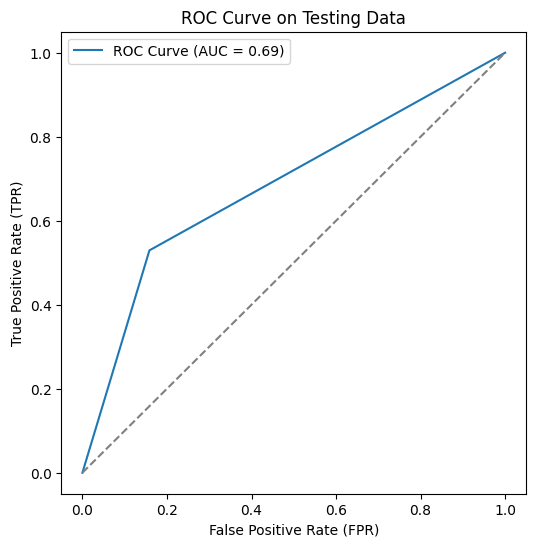

In [74]:
y_test_pred = best_model.predict(X_test)

cm_test = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm_test.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Compute the AUC-ROC score
roc_auc = roc_auc_score(y_test, y_test_pred)

# Print the AUC-ROC score
print(f"AUC-ROC Score: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)

# Plot the ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, linestyle='-', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve on Testing Data")
plt.legend()
plt.show()

In [80]:
# Extract the fitted steps
coefficients = best_model.named_steps['clf'].coef_.flatten()


# Pair each selected feature with its coefficient
feature_weights = list(zip(feature_names, coefficients))

# Sort features by absolute coefficient value (importance)
sorted_features = sorted(feature_weights, key=lambda x: abs(x[1]), reverse=True)

# Print top 20 most influential features
print("Top 20 features by absolute weight:")
for feature, weight in sorted_features[:20]:
    print(f"{feature}: {weight:.4f}")

non_zero_count = np.sum(coefficients != 0)
print(f"\nNumber of non-zero coefficients: {non_zero_count} out of {len(coefficients)}")

Top 20 features by absolute weight:
LOX: 0.1888
PDPK1: -0.1738
RACE_White: 0.1731
HTATSF1: 0.1533
HIST1H2AC: 0.1490
GNAS: 0.1428
SYN2: -0.1364
C11orf84: 0.1320
CDH1: 0.1208
ALS2CR8: 0.1206
ST14: 0.1202
HTR1F: 0.1179
EPHX2: -0.1169
AFAP1-AS1: 0.1161
FERMT3: -0.1148
SLC12A9: -0.1138
ADAMTS15: 0.1135
TREML1: -0.1129
CLCA2: 0.1125
EFCAB12: -0.1103

Number of non-zero coefficients: 1011 out of 17530


In [75]:
print(feature_names)

{0: 'AGE', 1: 'AJCC_STAGING_EDITION', 2: 'DAYS_TO_BIRTH', 3: 'DAYS_TO_INITIAL_PATHOLOGIC_DIAGNOSIS', 4: 'WEIGHT', 5: 'no_symbol_2', 6: 'UBE2Q2P2', 7: 'HMGB1P1', 8: 'no_symbol_3', 9: 'no_symbol_5', 10: 'EFCAB8', 11: 'SRP14P1', 12: 'no_symbol_9', 13: 'no_symbol_10', 14: 'HSPB1P1', 15: 'no_symbol_13', 16: 'GTPBP6', 17: 'EFCAB12', 18: 'A1BG', 19: 'A1CF', 20: 'A2BP1', 21: 'A2LD1', 22: 'A2M', 23: 'A2ML1', 24: 'A4GALT', 25: 'AAAS', 26: 'AACS', 27: 'AACSL', 28: 'AADAC', 29: 'AADAT', 30: 'AAGAB', 31: 'AAK1', 32: 'AAMP', 33: 'AANAT', 34: 'AARS', 35: 'AARS2', 36: 'AARSD1', 37: 'AASDH', 38: 'AASDHPPT', 39: 'AASS', 40: 'AATF', 41: 'AATK', 42: 'ABAT', 43: 'ABCA10', 44: 'ABCA1', 45: 'ABCA11P', 46: 'ABCA12', 47: 'ABCA13', 48: 'ABCA17P', 49: 'ABCA2', 50: 'ABCA3', 51: 'ABCA4', 52: 'ABCA5', 53: 'ABCA6', 54: 'ABCA7', 55: 'ABCA8', 56: 'ABCA9', 57: 'ABCB10', 58: 'ABCB1', 59: 'ABCB4', 60: 'ABCB5', 61: 'ABCB6', 62: 'ABCB7', 63: 'ABCB8', 64: 'ABCB9', 65: 'ABCC10', 66: 'ABCC11', 67: 'ABCC13', 68: 'ABCC1', 69: '